# Insurance Claim Fraud Detection

## Project Overview
This project builds a machine learning model to detect fraudulent insurance claims. The goal is to help insurance companies reduce financial losses by identifying suspicious claims.

**Author:** Steve
**Date:** 2026-01-31

In [15]:
import warnings
import pandas as pd
import joblib
import json
from datetime import datetime
from ipywidgets import interact
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix, classification_report, 
                             roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge, LogisticRegression
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import ipywidgets as widgets
warnings.filterwarnings("ignore",message="X does not have valid feature names")

## 2. Data Loading and Wrangling

In [2]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    df=df.drop(columns=["policy_number","age","policy_bind_date","insured_zip","_c39"])
    df=df.drop(columns=["insured_hobbies","insured_sex","insured_relationship"])
    df=df.drop(columns=["insured_education_level","incident_date","incident_location"])
    df=df.drop(columns=["incident_city","insured_occupation","policy_state","incident_state"])
    df["fraud_reported"]=df["fraud_reported"].map({"Y": 1, "N": 0})
    return df

In [3]:
df=wrangle("C:/Users/musyo/Downloads/Datasets-20240315/insurance_claims_fraud_detection.csv")
print("df Shape:",df.shape)
df.head()

df Shape: (1000, 25)


,months_as_customer,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_type,collision_type,incident_severity,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,250/500,1000,1406.91,0,53300,0,Single Vehicle Collision,Side Collision,Major Damage,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,250/500,2000,1197.22,5000000,0,0,Vehicle Theft,?,Minor Damage,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,100/300,2000,1413.14,5000000,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,250/500,2000,1415.74,6000000,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,500/1000,1000,1583.91,6000000,66000,-46000,Vehicle Theft,?,Minor Damage,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [4]:
df.columns.tolist()

['months_as_customer',
 'policy_csl',
 'policy_deductable',
 'policy_annual_premium',
 'umbrella_limit',
 'capital-gains',
 'capital-loss',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'property_damage',
 'bodily_injuries',
 'witnesses',
 'police_report_available',
 'total_claim_amount',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'auto_make',
 'auto_model',
 'auto_year',
 'fraud_reported']

In [36]:
df.describe()

,months_as_customer,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,1136.000000,1256.406150,1.101000e+06,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,0.247000
std,115.113174,611.864673,244.167395,2.297407e+06,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,0.431483
min,0.000000,500.000000,433.330000,-1.000000e+06,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,0.000000
25%,115.750000,500.000000,1089.607500,0.000000e+00,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000,0.000000
50%,199.500000,1000.000000,1257.200000,0.000000e+00,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,0.000000
75%,276.250000,2000.000000,1415.695000,0.000000e+00,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000,0.000000
max,479.000000,2000.000000,2047.590000,1.000000e+07,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   policy_csl                   1000 non-null   object 
 2   policy_deductable            1000 non-null   int64  
 3   policy_annual_premium        1000 non-null   float64
 4   umbrella_limit               1000 non-null   int64  
 5   capital-gains                1000 non-null   int64  
 6   capital-loss                 1000 non-null   int64  
 7   incident_type                1000 non-null   object 
 8   collision_type               1000 non-null   object 
 9   incident_severity            1000 non-null   object 
 10  authorities_contacted        909 non-null    object 
 11  incident_hour_of_the_day     1000 non-null   int64  
 12  number_of_vehicles_involved  1000 non-null   int64  
 13  property_damage    

## 3. Exploratory Data Analysis

Total claims: 1000
claims destribution: fraud_reported
0    753
1    247
Name: count, dtype: int64


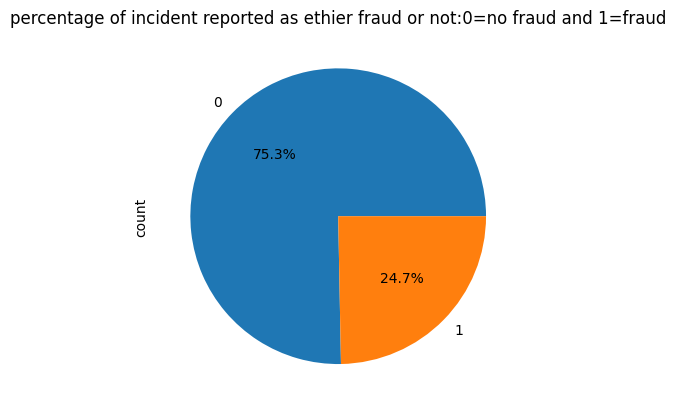

In [6]:
df["fraud_reported"].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("percentage of incident reported as ethier fraud or not:0=no fraud and 1=fraud");
print("Total claims:",df["fraud_reported"].value_counts().sum())
print("claims destribution:",df["fraud_reported"].value_counts())

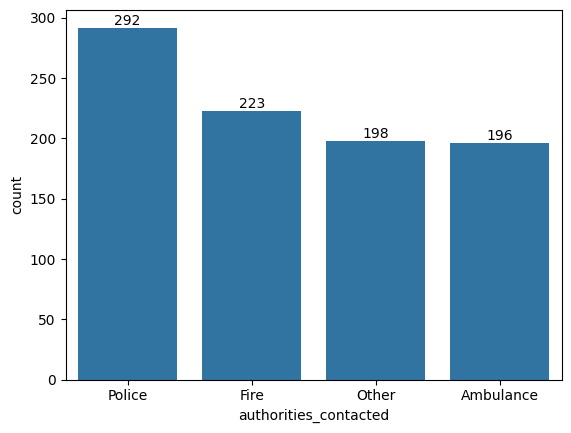

In [7]:
fig,ax=plt.subplots()
sns.countplot(df,x="authorities_contacted")
for container in ax.containers:
    ax.bar_label(container,fmt="%.f")

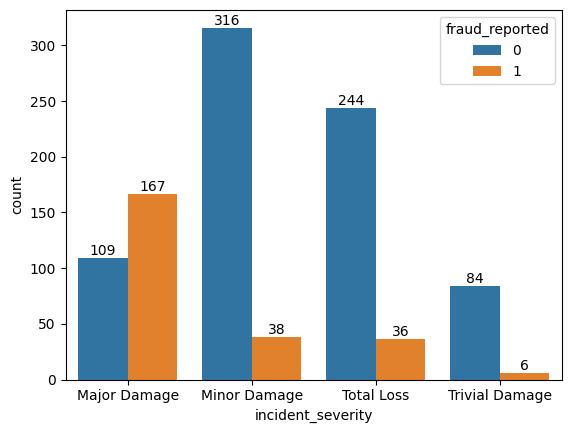

In [8]:
fig,ax=plt.subplots()
sns.countplot(data=df,x="incident_severity",hue="fraud_reported")
for container in ax.containers:
    ax.bar_label(container,fmt="%.f")

In [9]:
df.select_dtypes("object").nunique()

policy_csl                  3
incident_type               4
collision_type              4
incident_severity           4
authorities_contacted       4
property_damage             3
police_report_available     3
auto_make                  14
auto_model                 39
dtype: int64

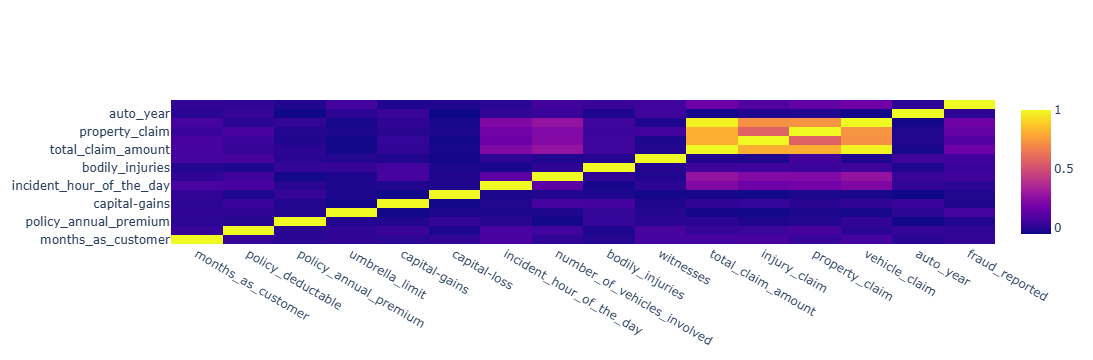

In [10]:
corr=df.select_dtypes("number").corr()
heat_mp=go.Heatmap(z=np.array(corr),x=corr.columns,y=corr.columns)
iplot([heat_mp])

## 4. Feature Engineering

In [8]:
traget="fraud_reported"
X=df.drop(columns=[traget])
y=df[traget]
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## 5. Train Test Split

In [9]:
X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)

## 6. Handle Class Imbalance

In [10]:
over=RandomOverSampler(random_state=42)
X_train_over,y_train_over=over.fit_resample(X_train,y_train)

In [13]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__num_leaves': [31, 50]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [5, 10, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 1]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
}

## 7. Model Training and Evaluation

In [16]:
results = []

for name, model_info in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', model_info['model'])
    ])
    
    pipe.fit(X_train_over, y_train_over)
    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba),
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.795,0.590909,0.530612,0.559140,0.773618
1,Gradient Boosting,0.785,0.557692,0.591837,0.574257,0.740641
2,XGBoost,0.750,0.488889,0.448980,0.468085,0.742398
3,LightGBM,0.765,0.522727,0.469388,0.494624,0.795513
4,SVM,0.795,0.562500,0.734694,0.637168,0.817273
5,K-Nearest Neighbors,0.620,0.351648,0.653061,0.457143,0.631910
6,Decision Tree,0.720,0.431373,0.448980,0.440000,0.628463
7,AdaBoost,0.810,0.590164,0.734694,0.654545,0.788417
8,Extra Trees,0.805,0.647059,0.448980,0.530120,0.794026


In [17]:
final_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

final_model.fit(X_train_over, y_train_over)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
acc_train = final_model.score(X_train_over,y_train_over)
acc_test =final_model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7533
Test Accuracy: 0.81


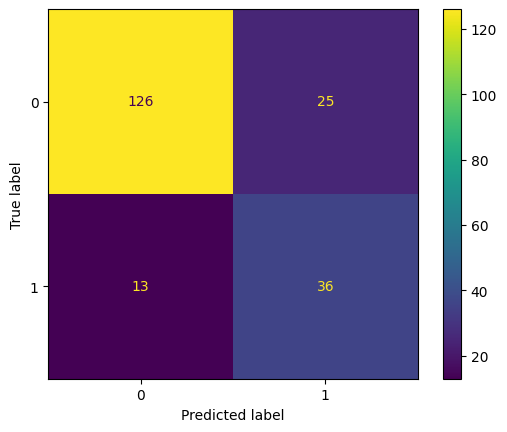

In [19]:
ConfusionMatrixDisplay.from_estimator(final_model,X_test,y_test);

In [20]:
print(classification_report(y_test,final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       151
           1       0.59      0.73      0.65        49

    accuracy                           0.81       200
   macro avg       0.75      0.78      0.76       200
weighted avg       0.83      0.81      0.82       200



In [21]:
def make_cnf_matrix(threshold):
    y_pred_proba=final_model.predict_proba(X_test)[:,-1]
    y_pred=y_pred_proba>threshold
    conf_metrixs=confusion_matrix(y_test,y_pred)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    
   


thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

In [27]:
# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d")
# Save best model
joblib.dump(final_model, f'final_model_{timestamp}.pkl')
print(f"final_model saved as: final_model_{timestamp}.pkl")

# Save preprocessing pipeline
joblib.dump(preprocessor, f'preprocessor_{timestamp}.pkl')
print(f"Preprocessor saved as: preprocessor_{timestamp}.pkl")


final_model saved as: final_model_20260131.pkl
Preprocessor saved as: preprocessor_20260131.pkl


In [33]:
def predict_fraud(new_data, model_path='final_model_20260131.pkl'):
    
    # Load trained pipeline model
    model = joblib.load(model_path)

    # Predictions
    fraud_probabilities = model.predict_proba(new_data)[:, 1]
    fraud_predictions = model.predict(new_data)

    # Results
    results = new_data.copy()
    results['fraud_probability'] = fraud_probabilities
    results['fraud_prediction'] = fraud_predictions
    results['risk_level'] = pd.cut(
        fraud_probabilities,
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Low', 'Medium', 'High']
    )

    return results

In [34]:
new_data = pd.read_csv("C:/Users/musyo/Downloads/insurance_claims_1.csv")

results = predict_fraud(new_data)

results.head()

,Unnamed: 0,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,...,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_probability,fraud_prediction,risk_level
0,0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,...,71610,6510,13020,52080,Saab,92x,2004,0.632356,1,Medium
1,1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,...,5070,780,780,3510,Mercedes,E400,2007,0.457621,0,Medium
2,2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,...,34650,7700,3850,23100,Dodge,RAM,2007,0.459199,0,Medium
3,3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,...,63400,6340,6340,50720,Chevrolet,Tahoe,2014,0.633013,1,Medium
4,4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,...,6500,1300,650,4550,Accura,RSX,2009,0.295735,0,Low
